# EDA + Preprocessing the Datset

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=a0098ec477c80ea9f3f98f150f0a106ac936fd1ccc0d605b23dd065a14c27d37
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
# Import Necessary Libraries
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, SimpleRNN, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

In [ ]:
# Load Dataset
data_path = '/content/drive/MyDrive/CSE 713 Project/Combined_Dataset.csv'
df = pd.read_csv(data_path)

In [ ]:
# Visualizing how the data looks like

df.head()

clean_text  is_depression
0  we understand that most people who reply immed...              1
1  welcome to r depression s check in post a plac...              1
2  anyone else instead of sleeping more when depr...              1
3  i ve kind of stuffed around a lot in my life d...              1
4  sleep is my greatest and most comforting escap...              1

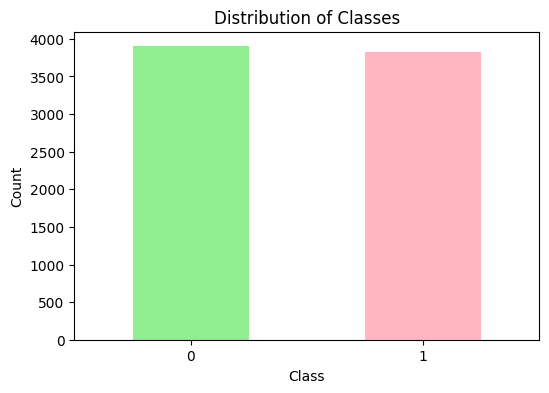

In [ ]:
# Visualize the dataset distribution

# Count the occurrences of each class
class_counts = df['is_depression'].value_counts()

# Create a bar plot to visualize the distribution of classes
# Adjust the figure size
plt.figure(figsize=(6, 4))
# Assuming '0' is green and '1' is red
class_counts.plot(kind='bar', color=['#90EE90', '#FFB6C1'])
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
# Rotate x-axis labels
plt.xticks(rotation=0)
plt.show()


In [ ]:
# Check data types in the dataframe

df.dtypes

clean_text       object
is_depression     int64
dtype: object

In [ ]:
# Split features and label

X = df['clean_text'].tolist()
y = df['is_depression']

In [ ]:
# Split into train and test set
# Random state = 434 ensures reproducibility

# Split into train data and prior test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=434)

# Further split test data into test and validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=434)

In [ ]:
# Save the train, test and validations splits (Before preprocessing)
# Create DataFrames for train, test, and validation sets
train_df = pd.DataFrame({'clean_text': X_train, 'is_depression': y_train})
test_df = pd.DataFrame({'clean_text': X_test, 'is_depression': y_test})
val_df = pd.DataFrame({'clean_text': X_val, 'is_depression': y_val})

# Save DataFrames to CSV files
train_df.to_csv('train_split.csv', index=False)
test_df.to_csv('test_split.csv', index=False)
val_df.to_csv('validation_split.csv', index=False)

In [ ]:
# converting y_train and y_test to numpy array

y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [ ]:
vocab_size = 10000 # Maximum number of words to keep, based on word frequency. Only the most common vocab_size words will be kept.
oov_token = "<OOV>" # This line sets the out-of-vocabulary token. Any word that is not in the word index gets converted to this string.
padding_type = "post" # padding will happen after the sequence
truncation_type="post" # truncation will happen after the sequence

In [ ]:
# Instantiate a tokenizer and fit the tokenizer

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token) # Initializing the tokenizer with the specified vocabulary size and out-of-vocabulary token.
tokenizer.fit_on_texts(X_train) # Fitting the tokenizer on the training texts. It updates internal vocabulary based on a list of texts.

In [ ]:
# Tokenize and pad the training and test set

X_train_sequences = tokenizer.texts_to_sequences(X_train) # This line converts the text to a sequence of integers. This part works on a list
X_test_sequences = tokenizer.texts_to_sequences(X_test) # This line converts the text to a sequence of integers. This part works on a list
X_val_sequences = tokenizer.texts_to_sequences(X_val)

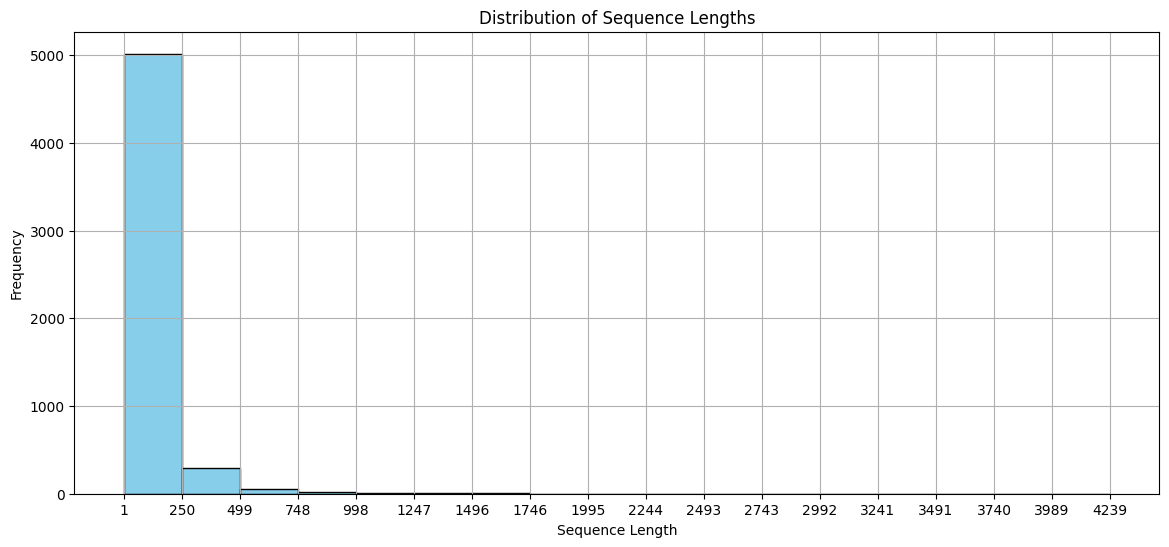

In [ ]:
# Visualize the length distribution of each instances
# Calculate lengths of each sequence
sequence_lengths = [len(seq) for seq in X_train_sequences]

# Plot histogram
plt.figure(figsize=(14, 6))
plt.hist(sequence_lengths, bins=17, color='skyblue', edgecolor='black')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(True)

# Customize x-axis ticks
bin_width = (max(sequence_lengths) - min(sequence_lengths)) / 17
x_ticks = [int(min(sequence_lengths) + i * bin_width) for i in range(18)]
plt.xticks(x_ticks)

plt.show()

From the above distribution we see that the most of the instances have a length of in between 0 to 250. So, we choose 256 to be the max_length

In [ ]:
# max_length of each instances

In [ ]:
max_length = 256

In [ ]:
X_train_padded = pad_sequences(X_train_sequences, maxlen = max_length, padding=padding_type, truncating=truncation_type) # The function, pad_sequences takes the sequence of integers (X_train_sequences) and truncates/pads them
X_test_padded = pad_sequences(X_test_sequences,maxlen = max_length, # The function, pad_sequences takes the sequence of integers (X_test_sequences) and truncates/pads them
                               padding=padding_type, truncating=truncation_type)
X_val_padded = pad_sequences(X_val_sequences, maxlen = max_length, padding = padding_type, truncating = truncation_type) # The function, pad_sequences takes the sequence of integers (X_val_sequences) and truncates/pads them

In [ ]:
# Create DataFrames for padded train, test, and validation sets
train_padded_df = pd.DataFrame({'Padded_text': X_train_padded.tolist(), 'is_depression': y_train})
test_padded_df = pd.DataFrame({'Padded_text': X_test_padded.tolist(), 'is_depression': y_test})
val_padded_df = pd.DataFrame({'Padded_text': X_val_padded.tolist(), 'is_depression': y_val})

# Save DataFrames to CSV files (After Preprocessing)
train_padded_df.to_csv('train_split_preprocessed', index=False)
test_padded_df.to_csv('test_split_preprocessed.csv', index=False)
val_padded_df.to_csv('validation_split_preprocessed.csv', index=False)


# Load GloVe Embeddings and create embedding layer

In [ ]:
# Load GloVe embeddings (Create a dictionary of format -> 'words: word embeddings' from GloVe)

embeddings_index = {} # An empty dictionary is initialized. After this dictionary is filled up the keys will be the words, and the values will be the embeddings of the words.
glove_path = '/content/drive/MyDrive/CSE 713 Project/GloVe Embeddings/glove.6B.100d - Copy.txt' # Path to the glove embeddings text file.

f = open(glove_path) # This line opens the file at the location specified by glove_path. The file is expected to contain the GloVe word embeddings. The file handle is stored in the variable f. (INVESTIGATE LATER TO SEE WHAT IT EXACTLY MEANS)
for line in f: # This line starts a loop that iterates over each line in the file. Each line in the file has a word along with its word vector.
    values = line.split() # This line splits the line into a list of strings, using whitespace as the delimiter. The first string in the list is the word, and the remaining strings are the components of the word’s embedding vector.
    word = values[0] # This line extracts the first string from the list, which is the word.
    coefs = np.asarray(values[1:], dtype='float32') #  This line converts the remaining strings in the list (i.e., values[1:]) into a numpy array of floating point numbers. This array represents the word’s embedding vector.
    embeddings_index[word] = coefs # This line adds the 'word' as the 'key' and its corresponding embedding vector, 'coefs' as the 'value' to the dictionary embeddings_index.
f.close() # This line closes the file. It’s good practice to close files as soon as you’re done with them to free up system resources. Probably the file was loaded in the memory now we are freeing the memory.

print('Found %s word vectors.' % len(embeddings_index)) # Print how many word embeddings have been found. It looks like there are embeddings of 13452 words.

Found 400000 word vectors.


In [ ]:
word_index = tokenizer.word_index # This line retrieves the word index that was learned by the tokenizer. The word index is a dictionary where the keys are the words and the values are the corresponding integer indices. It is stored in the variable word_index.

In [ ]:
embedding_dim = 100 # This line sets the size of the embedding vectors. In this case, each word will be represented as a 100-dimensional vector.

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim)) # Why is the 1 being added? Isn't len() function supposed to give me the exact length? Seems like copilot has an answer for this (verify this with gpt and gemini) Creating an empty embedding matrix with dimension words x embeddings.
for word, i in word_index.items(): # The for loop iterates over each word and its corresponding index. The 'word' contains the actual word and 'i' contains the word index from the tokenizer.
    embedding_vector = embeddings_index.get(word) # From the dictionary 'embeddings_index' get the 'value' (embeddings) for the key 'word'
    if embedding_vector is not None: # If the 'word' is not found as a key from the dictionary the 'embedding_vector' is returned as 'None' in the above code. If the value of embedding_vector is not None, we add 'word embeddings' in the 'embedding_matrix' at the corresponding 'index' position of the word. If the 'word' from the tokenizer is not found in the embeddings dictionary loaded from Glove, the value of the row of that index position of the word in the matrix remains zero.
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector # Assing the word's embeddings to its index position in the embedding_matrix.

In [ ]:
embedding_layer = Embedding(input_dim=len(word_index) + 1, # The row number of the embedding matrix (vocab size)
                            output_dim=embedding_dim, # The column number of the embeddings matrix (dimension of the embeddings)
                            weights=[embedding_matrix], # The initial weights are set to the emebeddings matrix (though these are the final ones as they are not trainable)
                            input_length=max_length, # The input length of the input sequence is set to the max_length
                            trainable=False) # The embeddings are not trainable

# Train and Evaluate the RNN models

In [ ]:
# Define the callbacks

patience = 3
early_stopping = EarlyStopping(monitor='val_accuracy', patience = patience)
model_checkpoint = ModelCheckpoint('best_model_2.h5', monitor='val_accuracy', save_best_only=True)

## Model 1 (Unidirectional Simple RNN)

In [ ]:
# Define the model

n_rnn = 32
model1 = Sequential([
    embedding_layer,
    SimpleRNN(n_rnn, return_sequences=False),
    Dense(1, activation='sigmoid')
])

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
%%time
# Train the model

history1 = model1.fit(
    X_train_padded, y_train, epochs=50, batch_size=32, validation_data = (X_val_padded, y_val), callbacks = [early_stopping, model_checkpoint]
)

Epoch 1/50
170/170 [==============================] - 60s 312ms/step - loss: 0.6560 - accuracy: 0.5561 - val_loss: 0.6292 - val_accuracy: 0.6078
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


170/170 [==============================] - 35s 206ms/step - loss: 0.6468 - accuracy: 0.5650 - val_loss: 0.6308 - val_accuracy: 0.5957
Epoch 3/50
170/170 [==============================] - 37s 218ms/step - loss: 0.6425 - accuracy: 0.5712 - val_loss: 0.6510 - val_accuracy: 0.5466
Epoch 4/50
170/170 [==============================] - 34s 201ms/step - loss: 0.6440 - accuracy: 0.5594 - val_loss: 0.6172 - val_accuracy: 0.6612
Epoch 5/50
170/170 [==============================] - 38s 222ms/step - loss: 0.6409 - accuracy: 0.5809 - val_loss: 0.6562 - val_accuracy: 0.4991
Epoch 6/50
170/170 [==============================] - 34s 200ms/step - loss: 0.6417 - accuracy: 0.5744 - val_loss: 0.6206 - val_accuracy: 0.6440
Epoch 7/50
170/170 [==============================] - 36s 209ms/step - loss: 0.6395 - accuracy: 0.5892 - val_loss: 0.6283 - val_accuracy: 0.6017
CPU times: user 5min 38s, sys: 35.3 s, total: 6min 13s
Wall time: 4min 33s


In [ ]:
# Save Model history
# Specify the path to your Google Drive
path = "/content/drive/MyDrive/CSE 713 Project/Trained Models/Model_1_S_RNN/"

# Save the file to Google Drive
json.dump(str(history1.history), open(path + 'history1.json', 'w'))


# Load the model history
# Load the file from Google Drive
history1_dict = json.load(open(path + 'history1.json', 'r'))

# Convert the string back to a dictionary
history1_dict = eval(history1_dict)

In [ ]:
# Save the model
save_dir = '/content/drive/MyDrive/CSE 713 Project/Trained Models/Model_1_S_RNN'
os.makedirs(save_dir, exist_ok=True)
model1.save(os.path.join(save_dir, 'model1.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load model
loaded_model = keras.models.load_model('/content/drive/MyDrive/CSE 713 Project/Trained Models/model1.h5')

In [ ]:
# Evaluate loaded model

# Make predictions on the test set
y_pred_prob1 = loaded_model1.predict(X_test_padded)
y_pred1 = (y_pred_prob1 > 0.5).astype("int32")

# Calculate precision, recall, and F1-score on the test set
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred1, digits = 4))


37/37 [==============================] - 2s 54ms/step
              precision    recall  f1-score   support

           0     0.5426    0.8852    0.6728       575
           1     0.7027    0.2667    0.3866       585

    accuracy                         0.5733      1160
   macro avg     0.6227    0.5759    0.5297      1160
weighted avg     0.6234    0.5733    0.5285      1160



Confusion Matrix:
[[509  66]
 [429 156]]


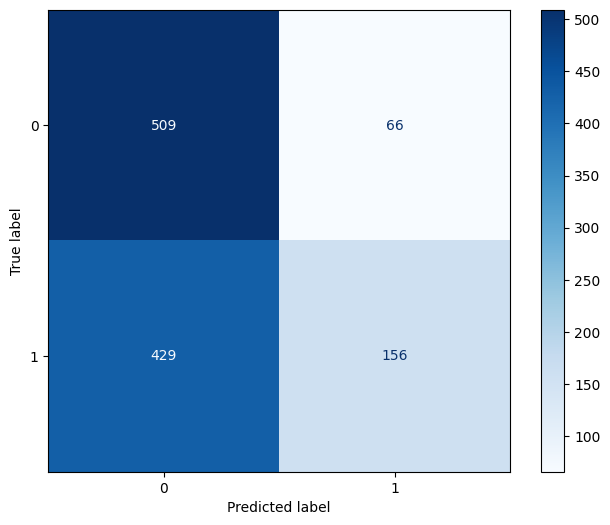

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred1)
print("Confusion Matrix:")
print(conf_matrix)
from sklearn.metrics import ConfusionMatrixDisplay
#Confusion matrix plot
fig, ax = plt.subplots(figsize=(8, 6))
cmd = ConfusionMatrixDisplay(conf_matrix)
cmd.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Predict Depression for a text Instance

def Predict_depression(model, tokenizer, text):
  tokenized_text = tokenizer.texts_to_sequences([text])
  tokenized_text_padded = pad_sequences(tokenized_text, maxlen = max_length, padding = padding_type, truncating = truncation_type)
  y_pred_prob = model.predict(tokenized_text_padded.reshape(1, -1))[0][0]
  print(text)
  if y_pred_prob >= 0.5:
    print('Depressed.')
  else:
    print('Not depressed.')

In [ ]:
Predict_depression(loaded_model, tokenizer, X_train[0])

1/1 [==============================] - 0s 46ms/step
Not depressed.


## Model 2 (Bidirectional Simple RNN)

In [ ]:
# Define the model

n_rnn = 32
model2 = Sequential([
    embedding_layer,
    Bidirectional(SimpleRNN(n_rnn, return_sequences=False)),
    Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
%%time
# Train the model

history2 = model2.fit(
    X_train_padded, y_train, epochs=50, batch_size=32, validation_data = (X_val_padded, y_val), callbacks = [early_stopping, model_checkpoint]
)

Epoch 1/50
170/170 [==============================] - 140s 802ms/step - loss: 0.5553 - accuracy: 0.7060 - val_loss: 0.3296 - val_accuracy: 0.8819
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


170/170 [==============================] - 73s 426ms/step - loss: 0.4195 - accuracy: 0.8019 - val_loss: 0.3659 - val_accuracy: 0.8422
Epoch 3/50
170/170 [==============================] - 66s 392ms/step - loss: 0.2410 - accuracy: 0.9057 - val_loss: 0.1736 - val_accuracy: 0.9422
Epoch 4/50
170/170 [==============================] - 62s 365ms/step - loss: 0.1586 - accuracy: 0.9477 - val_loss: 0.1939 - val_accuracy: 0.9353
Epoch 5/50
170/170 [==============================] - 67s 395ms/step - loss: 0.1390 - accuracy: 0.9510 - val_loss: 0.1380 - val_accuracy: 0.9586
Epoch 6/50
170/170 [==============================] - 65s 384ms/step - loss: 0.2577 - accuracy: 0.8974 - val_loss: 0.1713 - val_accuracy: 0.9534
Epoch 7/50
170/170 [==============================] - 63s 369ms/step - loss: 0.2230 - accuracy: 0.9098 - val_loss: 0.2026 - val_accuracy: 0.9198
Epoch 8/50
170/170 [==============================] - 63s 370ms/step - loss: 0.2139 - accuracy: 0.9078 - val_loss: 0.1907 - val_accuracy: 0.9

In [ ]:
# Save Model history
# Specify the path to your Google Drive
path = "/content/drive/MyDrive/CSE 713 Project/Trained Models/Model_2_Bi_S_RNN/"

# Save the file to Google Drive
json.dump(str(history2.history), open(path + 'history2.json', 'w'))


# Load the model history
# Load the file from Google Drive
history2_dict = json.load(open(path + 'history2.json', 'r'))

# Convert the string back to a dictionary
history2_dict = eval(history2_dict)

In [ ]:
# Save the model
save_dir = '/content/drive/MyDrive/CSE 713 Project/Trained Models/Model_2_Bi_S_RNN'
os.makedirs(save_dir, exist_ok=True)
model2.save(os.path.join(save_dir, 'model2.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load model
loaded_model2 = keras.models.load_model('/content/drive/MyDrive/CSE 713 Project/Trained Models/Model_2_Bi_S_RNN/model2.h5')

In [ ]:
# Evaluate loaded model

# Make predictions on the test set
y_pred_prob2 = loaded_model2.predict(X_test_padded)
y_pred2 = (y_pred_prob2 > 0.5).astype("int32")

# Calculate precision, recall, and F1-score on the test set
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred2, digits = 4))


37/37 [==============================] - 2s 41ms/step
              precision    recall  f1-score   support

           0     0.8725    0.9757    0.9212       575
           1     0.9729    0.8598    0.9129       585

    accuracy                         0.9172      1160
   macro avg     0.9227    0.9177    0.9170      1160
weighted avg     0.9231    0.9172    0.9170      1160



Confusion Matrix:
[[561  14]
 [ 82 503]]


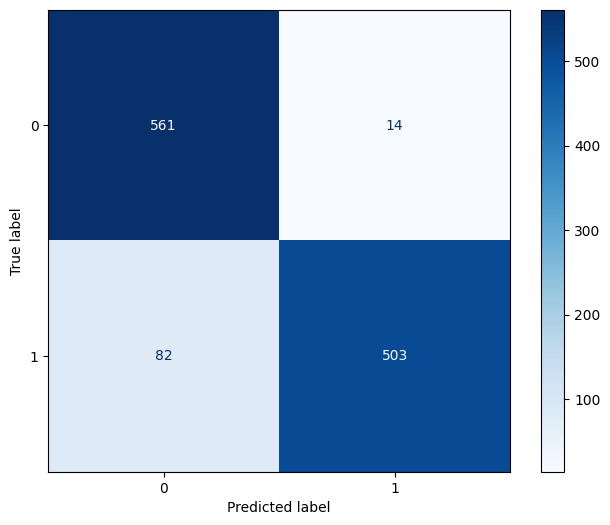

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred2)
print("Confusion Matrix:")
print(conf_matrix)
from sklearn.metrics import ConfusionMatrixDisplay
#Confusion matrix plot
fig, ax = plt.subplots(figsize=(8, 6))
cmd = ConfusionMatrixDisplay(conf_matrix)
cmd.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Predict Depression for a text Instance

def Predict_depression(model, tokenizer, text):
  tokenized_text = tokenizer.texts_to_sequences([text])
  tokenized_text_padded = pad_sequences(tokenized_text, maxlen = max_length, padding = padding_type, truncating = truncation_type)
  y_pred_prob = model.predict(tokenized_text_padded.reshape(1, -1))[0][0]
  print(text)
  if y_pred_prob >= 0.5:
    print('Depressed.')
  else:
    print('Not depressed.')

In [ ]:
Predict_depression(loaded_model2, tokenizer, X_train[1])

1/1 [==============================] - 0s 79ms/step
Not depressed.


## Model 3 (Unidirectional LSTM)

In [ ]:
# Define the model

n_lstm = 32
model3 = Sequential([
    embedding_layer,
    LSTM(n_lstm, return_sequences=False),
    Dense(1, activation='sigmoid')
])

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
%%time
# Train the model

history3 = model3.fit(
    X_train_padded, y_train, epochs=50, batch_size=32, validation_data = (X_val_padded, y_val), callbacks = [early_stopping, model_checkpoint]
)

Epoch 1/50
170/170 [==============================] - 6s 21ms/step - loss: 0.6455 - accuracy: 0.5908 - val_loss: 0.6168 - val_accuracy: 0.6250
Epoch 2/50
170/170 [==============================] - 2s 12ms/step - loss: 0.6193 - accuracy: 0.6128 - val_loss: 0.6088 - val_accuracy: 0.6379
Epoch 3/50
170/170 [==============================] - 2s 12ms/step - loss: 0.6148 - accuracy: 0.6158 - val_loss: 0.5932 - val_accuracy: 0.6578
Epoch 4/50
170/170 [==============================] - 2s 13ms/step - loss: 0.4642 - accuracy: 0.7677 - val_loss: 0.3117 - val_accuracy: 0.8853
Epoch 5/50
170/170 [==============================] - 2s 12ms/step - loss: 0.3116 - accuracy: 0.8767 - val_loss: 0.5033 - val_accuracy: 0.8845
Epoch 6/50
170/170 [==============================] - 2s 13ms/step - loss: 0.3011 - accuracy: 0.8930 - val_loss: 0.3816 - val_accuracy: 0.8328
Epoch 7/50
170/170 [==============================] - 3s 17ms/step - loss: 0.3428 - accuracy: 0.8586 - val_loss: 0.3075 - val_accuracy: 0.8784

In [ ]:
# Save Model history
# Specify the path to your Google Drive
path = "/content/drive/MyDrive/CSE 713 Project/Trained Models/Model_3_LSTM/"

# Save the file to Google Drive
json.dump(str(history3.history), open(path + 'history3.json', 'w'))


# Load the model history
# Load the file from Google Drive
history3_dict = json.load(open(path + 'history3.json', 'r'))

# Convert the string back to a dictionary
history3_dict = eval(history3_dict)

In [ ]:
# Save the model
save_dir = '/content/drive/MyDrive/CSE 713 Project/Trained Models/Model_3_LSTM'
os.makedirs(save_dir, exist_ok=True)
model3.save(os.path.join(save_dir, 'model3.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load model
loaded_model3 = keras.models.load_model('/content/drive/MyDrive/CSE 713 Project/Trained Models/Model_3_LSTM/model3.h5')

In [ ]:
# Evaluate loaded model

# Make predictions on the test set
y_pred_prob3 = loaded_model3.predict(X_test_padded)
y_pred3 = (y_pred_prob3 > 0.5).astype("int32")

# Calculate precision, recall, and F1-score on the test set
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred3, digits = 4))


37/37 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0     0.7997    1.0000    0.8887       575
           1     1.0000    0.7538    0.8596       585

    accuracy                         0.8759      1160
   macro avg     0.8999    0.8769    0.8742      1160
weighted avg     0.9007    0.8759    0.8741      1160



Confusion Matrix:
[[575   0]
 [144 441]]


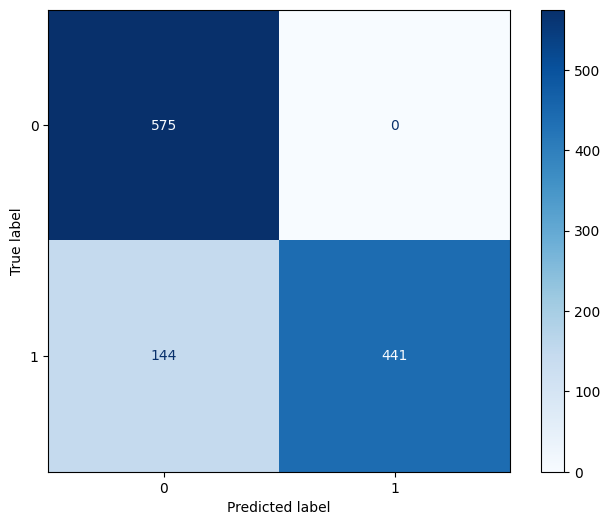

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred3)
print("Confusion Matrix:")
print(conf_matrix)
from sklearn.metrics import ConfusionMatrixDisplay
#Confusion matrix plot
fig, ax = plt.subplots(figsize=(8, 6))
cmd = ConfusionMatrixDisplay(conf_matrix)
cmd.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Predict Depression for a text Instance

def Predict_depression(model, tokenizer, text):
  tokenized_text = tokenizer.texts_to_sequences([text])
  tokenized_text_padded = pad_sequences(tokenized_text, maxlen = max_length, padding = padding_type, truncating = truncation_type)
  y_pred_prob = model.predict(tokenized_text_padded.reshape(1, -1))[0][0]
  print(text)
  if y_pred_prob >= 0.5:
    print('Depressed.')
  else:
    print('Not depressed.')

In [ ]:
Predict_depression(loaded_model3, tokenizer, X_train[1])

1/1 [==============================] - 0s 97ms/step
Not depressed.


## Model 4 (Bidirectional LSTM)

In [ ]:
# Define the model

n_lstm = 32
model4 = Sequential([
    embedding_layer,
    Bidirectional(LSTM(n_lstm, return_sequences=False)),
    Dense(1, activation='sigmoid')
])

model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
%%time
# Train the model

history4 = model4.fit(
    X_train_padded, y_train, epochs=50, batch_size=32, validation_data = (X_val_padded, y_val), callbacks = [early_stopping, model_checkpoint]
)

Epoch 1/50
170/170 [==============================] - 9s 31ms/step - loss: 0.3100 - accuracy: 0.8679 - val_loss: 0.1389 - val_accuracy: 0.9638
Epoch 2/50
  7/170 [>.............................] - ETA: 3s - loss: 0.1138 - accuracy: 0.9777

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


170/170 [==============================] - 4s 22ms/step - loss: 0.1260 - accuracy: 0.9590 - val_loss: 0.1095 - val_accuracy: 0.9655
Epoch 3/50
170/170 [==============================] - 4s 21ms/step - loss: 0.1007 - accuracy: 0.9673 - val_loss: 0.0980 - val_accuracy: 0.9690
Epoch 4/50
170/170 [==============================] - 5s 27ms/step - loss: 0.0915 - accuracy: 0.9665 - val_loss: 0.0890 - val_accuracy: 0.9707
Epoch 5/50
170/170 [==============================] - 3s 20ms/step - loss: 0.0830 - accuracy: 0.9678 - val_loss: 0.1044 - val_accuracy: 0.9698
Epoch 6/50
170/170 [==============================] - 3s 21ms/step - loss: 0.0827 - accuracy: 0.9699 - val_loss: 0.0864 - val_accuracy: 0.9724
Epoch 7/50
170/170 [==============================] - 4s 25ms/step - loss: 0.0686 - accuracy: 0.9749 - val_loss: 0.0853 - val_accuracy: 0.9707
Epoch 8/50
170/170 [==============================] - 4s 23ms/step - loss: 0.0607 - accuracy: 0.9773 - val_loss: 0.0769 - val_accuracy: 0.9733
Epoch 9/50

In [ ]:
# Save Model history
# Specify the path to your Google Drive
path = "/content/drive/MyDrive/CSE 713 Project/Trained Models/Model_4_Bi_LSTM/"

# Save the file to Google Drive
json.dump(str(history4.history), open(path + 'history4.json', 'w'))


# Load the model history
# Load the file from Google Drive
history4_dict = json.load(open(path + 'history4.json', 'r'))

# Convert the string back to a dictionary
history4_dict = eval(history4_dict)

In [ ]:
# Save the model
save_dir = '/content/drive/MyDrive/CSE 713 Project/Trained Models/Model_4_Bi_LSTM'
os.makedirs(save_dir, exist_ok=True)
model4.save(os.path.join(save_dir, 'model4.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load model
loaded_model4 = keras.models.load_model('/content/drive/MyDrive/CSE 713 Project/Trained Models/Model_4_Bi_LSTM/model4.h5')

In [ ]:
# Evaluate loaded model

# Make predictions on the test set
y_pred_prob4 = loaded_model4.predict(X_test_padded)
y_pred4 = (y_pred_prob4 > 0.5).astype("int32")

# Calculate precision, recall, and F1-score on the test set
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred4, digits = 4))


37/37 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0     0.9660    0.9878    0.9768       575
           1     0.9878    0.9658    0.9767       585

    accuracy                         0.9767      1160
   macro avg     0.9769    0.9768    0.9767      1160
weighted avg     0.9770    0.9767    0.9767      1160



Confusion Matrix:
[[568   7]
 [ 20 565]]


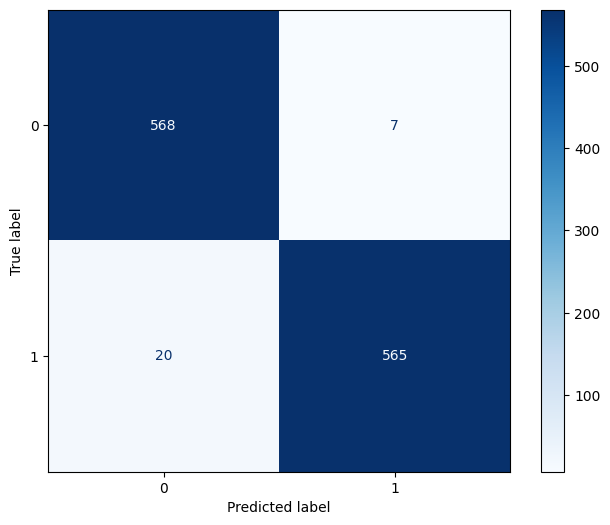

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred4)
print("Confusion Matrix:")
print(conf_matrix)
from sklearn.metrics import ConfusionMatrixDisplay
#Confusion matrix plot
fig, ax = plt.subplots(figsize=(8, 6))
cmd = ConfusionMatrixDisplay(conf_matrix)
cmd.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Predict Depression for a text Instance

def Predict_depression(model, tokenizer, text):
  tokenized_text = tokenizer.texts_to_sequences([text])
  tokenized_text_padded = pad_sequences(tokenized_text, maxlen = max_length, padding = padding_type, truncating = truncation_type)
  y_pred_prob = model.predict(tokenized_text_padded.reshape(1, -1))[0][0]
  print(text)
  if y_pred_prob >= 0.5:
    print('Depressed.')
  else:
    print('Not depressed.')

In [ ]:
Predict_depression(loaded_model4, tokenizer, X_train[20])

1/1 [==============================] - 0s 99ms/step
Depressed.


## Model 5 (Unidirectional GRU)

In [ ]:
# Define the model

n_gru = 32
model5 = Sequential([
    embedding_layer,
    GRU(n_gru, return_sequences=False),
    Dense(1, activation='sigmoid')
])

model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
%%time
# Train the model

history5 = model5.fit(
    X_train_padded, y_train, epochs=50, batch_size=32, validation_data = (X_val_padded, y_val), callbacks = [early_stopping, model_checkpoint]
)

Epoch 1/50
170/170 [==============================] - 6s 23ms/step - loss: 0.6458 - accuracy: 0.5844 - val_loss: 0.5954 - val_accuracy: 0.6509
Epoch 2/50
170/170 [==============================] - 3s 17ms/step - loss: 0.3904 - accuracy: 0.8313 - val_loss: 0.3354 - val_accuracy: 0.8664
Epoch 3/50
170/170 [==============================] - 2s 13ms/step - loss: 0.2119 - accuracy: 0.9313 - val_loss: 0.1597 - val_accuracy: 0.9543
Epoch 4/50
170/170 [==============================] - 2s 12ms/step - loss: 0.1810 - accuracy: 0.9446 - val_loss: 0.1981 - val_accuracy: 0.9379
Epoch 5/50
170/170 [==============================] - 2s 12ms/step - loss: 0.1499 - accuracy: 0.9560 - val_loss: 0.1558 - val_accuracy: 0.9543
Epoch 6/50
170/170 [==============================] - 2s 15ms/step - loss: 0.2220 - accuracy: 0.9279 - val_loss: 0.1537 - val_accuracy: 0.9560
Epoch 7/50
170/170 [==============================] - 3s 16ms/step - loss: 0.1381 - accuracy: 0.9603 - val_loss: 0.1465 - val_accuracy: 0.9586

In [ ]:
# Save Model history
# Specify the path to your Google Drive
path = "/content/drive/MyDrive/CSE 713 Project/Trained Models/Model_5_GRU/"

# Save the file to Google Drive
json.dump(str(history5.history), open(path + 'history5.json', 'w'))


# Load the model history
# Load the file from Google Drive
history5_dict = json.load(open(path + 'history5.json', 'r'))

# Convert the string back to a dictionary
history5_dict = eval(history5_dict)

In [ ]:
# Save the model
save_dir = '/content/drive/MyDrive/CSE 713 Project/Trained Models/Model_5_GRU'
os.makedirs(save_dir, exist_ok=True)
model5.save(os.path.join(save_dir, 'model5.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load model
loaded_model5 = keras.models.load_model('/content/drive/MyDrive/CSE 713 Project/Trained Models/Model_5_GRU/model5.h5')

In [ ]:
# Evaluate loaded model

# Make predictions on the test set
y_pred_prob5 = loaded_model5.predict(X_test_padded)
y_pred5 = (y_pred_prob5 > 0.5).astype("int32")

# Calculate precision, recall, and F1-score on the test set
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred5, digits = 4))


37/37 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0     0.9510    0.9791    0.9649       575
           1     0.9789    0.9504    0.9644       585

    accuracy                         0.9647      1160
   macro avg     0.9649    0.9648    0.9647      1160
weighted avg     0.9651    0.9647    0.9647      1160



Confusion Matrix:
[[563  12]
 [ 29 556]]


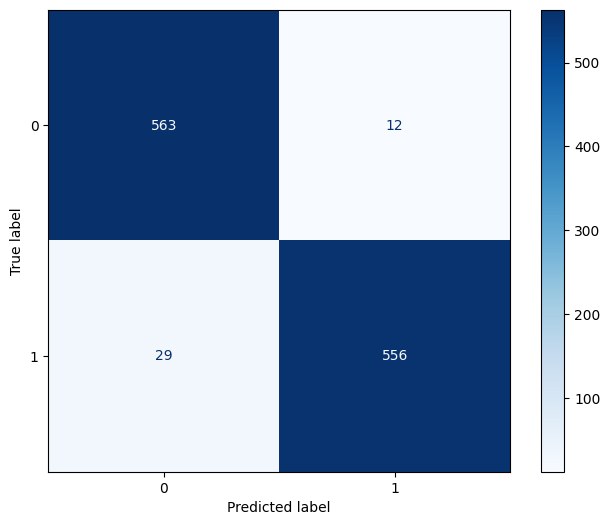

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred5)
print("Confusion Matrix:")
print(conf_matrix)
from sklearn.metrics import ConfusionMatrixDisplay
#Confusion matrix plot
fig, ax = plt.subplots(figsize=(8, 6))
cmd = ConfusionMatrixDisplay(conf_matrix)
cmd.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Predict Depression for a text Instance

def Predict_depression(model, tokenizer, text):
  tokenized_text = tokenizer.texts_to_sequences([text])
  tokenized_text_padded = pad_sequences(tokenized_text, maxlen = max_length, padding = padding_type, truncating = truncation_type)
  y_pred_prob = model.predict(tokenized_text_padded.reshape(1, -1))[0][0]
  print(text)
  if y_pred_prob >= 0.5:
    print('Depressed.')
  else:
    print('Not depressed.')

In [ ]:
Predict_depression(loaded_model5, tokenizer, X_train[20])

1/1 [==============================] - 0s 99ms/step
Depressed.


## Model 6 (Bidirectional GRU)

In [ ]:
# Define the model

n_gru = 32
model6 = Sequential([
    embedding_layer,
    Bidirectional(GRU(n_gru, return_sequences=False)),
    Dense(1, activation='sigmoid')
])

model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

NameError: name 'embedding_layer' is not defined

In [ ]:
%%time
# Train the model

history6 = model6.fit(
    X_train_padded, y_train, epochs=50, batch_size=32, validation_data = (X_val_padded, y_val), callbacks = [early_stopping, model_checkpoint]
)

Epoch 1/50
170/170 [==============================] - 9s 27ms/step - loss: 0.4141 - accuracy: 0.7947 - val_loss: 0.1413 - val_accuracy: 0.9569
Epoch 2/50
170/170 [==============================] - 4s 21ms/step - loss: 0.1209 - accuracy: 0.9601 - val_loss: 0.1073 - val_accuracy: 0.9655
Epoch 3/50
170/170 [==============================] - 4s 26ms/step - loss: 0.0992 - accuracy: 0.9671 - val_loss: 0.1135 - val_accuracy: 0.9647
Epoch 4/50
170/170 [==============================] - 4s 21ms/step - loss: 0.0875 - accuracy: 0.9697 - val_loss: 0.1031 - val_accuracy: 0.9664
Epoch 5/50
170/170 [==============================] - 3s 20ms/step - loss: 0.0822 - accuracy: 0.9695 - val_loss: 0.0866 - val_accuracy: 0.9698
Epoch 6/50
170/170 [==============================] - 4s 23ms/step - loss: 0.0712 - accuracy: 0.9749 - val_loss: 0.0921 - val_accuracy: 0.9716
Epoch 7/50
170/170 [==============================] - 4s 22ms/step - loss: 0.0658 - accuracy: 0.9747 - val_loss: 0.0834 - val_accuracy: 0.9733

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


170/170 [==============================] - 3s 20ms/step - loss: 0.0418 - accuracy: 0.9843 - val_loss: 0.0769 - val_accuracy: 0.9733
Epoch 12/50
170/170 [==============================] - 3s 20ms/step - loss: 0.0391 - accuracy: 0.9863 - val_loss: 0.0762 - val_accuracy: 0.9767
Epoch 13/50
170/170 [==============================] - 3s 20ms/step - loss: 0.0303 - accuracy: 0.9902 - val_loss: 0.0832 - val_accuracy: 0.9733
Epoch 14/50
170/170 [==============================] - 5s 27ms/step - loss: 0.0279 - accuracy: 0.9908 - val_loss: 0.0922 - val_accuracy: 0.9750
Epoch 15/50
170/170 [==============================] - 3s 20ms/step - loss: 0.0203 - accuracy: 0.9932 - val_loss: 0.0917 - val_accuracy: 0.9724
CPU times: user 1min 3s, sys: 2.29 s, total: 1min 5s
Wall time: 1min 1s


In [ ]:
# Save Model history
# Specify the path to your Google Drive
path = "/content/drive/MyDrive/CSE 713 Project/Trained Models/Model_6_Bi_GRU/"

# Save the file to Google Drive
json.dump(str(history6.history), open(path + 'history6.json', 'w'))


# Load the model history
# Load the file from Google Drive
history6_dict = json.load(open(path + 'history6.json', 'r'))

# Convert the string back to a dictionary
history6_dict = eval(history6_dict)

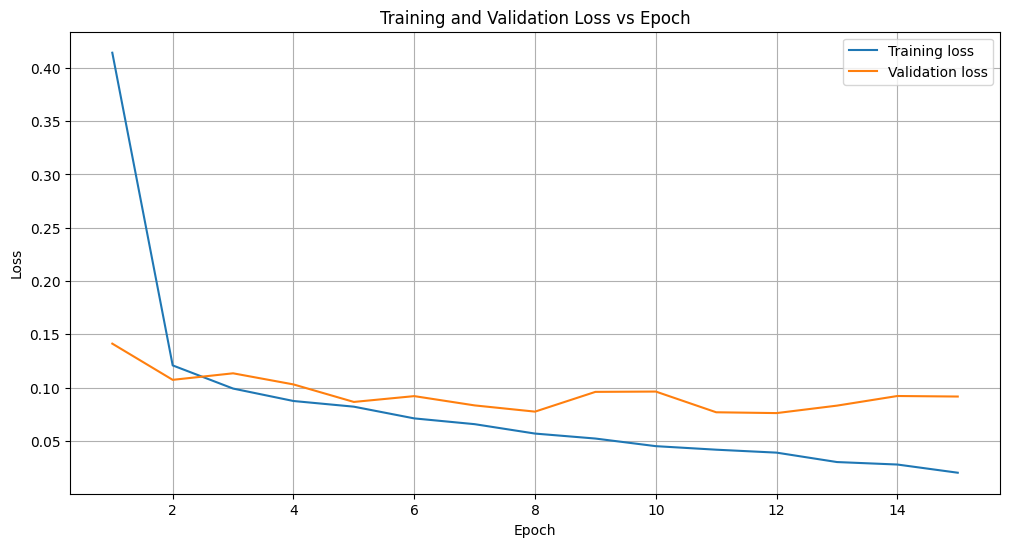

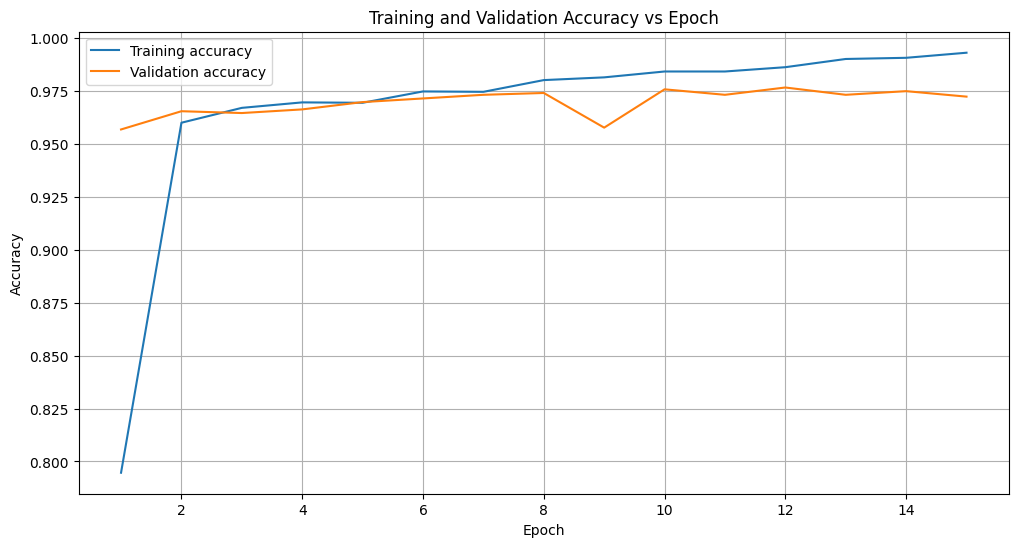

In [ ]:
loss = history6_dict['loss']
accuracy = history6_dict['accuracy']
val_loss = history6_dict['val_loss']
val_accuracy = history6_dict['val_accuracy']

# Number of epochs
epochs = range(1, len(loss) + 1)

# Plotting loss vs epoch
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy vs epoch
plt.figure(figsize=(12, 6))
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save the model
save_dir = '/content/drive/MyDrive/CSE 713 Project/Trained Models/Model_6_Bi_GRU'
os.makedirs(save_dir, exist_ok=True)
model6.save(os.path.join(save_dir, 'model6.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load model
loaded_model6 = keras.models.load_model('/content/drive/MyDrive/CSE 713 Project/Trained Models/Model_6_Bi_GRU/model6.h5')

In [ ]:
# Evaluate loaded model

# Make predictions on the test set
y_pred_prob6 = loaded_model6.predict(X_test_padded)
y_pred6 = (y_pred_prob6 > 0.5).astype("int32")

# Calculate precision, recall, and F1-score on the test set
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred6, digits = 4))


37/37 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

           0     0.9741    0.9826    0.9784       575
           1     0.9828    0.9744    0.9785       585

    accuracy                         0.9784      1160
   macro avg     0.9784    0.9785    0.9784      1160
weighted avg     0.9785    0.9784    0.9784      1160



In [ ]:
# Get the indices where y_pred values are not equal to y_test
indices = [index for index, (pred, actual) in enumerate(zip(y_pred6, y_test)) if pred != actual]

print("Indices where y_pred values are not equal to y_test:", indices)

Indices where y_pred values are not equal to y_test: [37, 64, 89, 107, 191, 265, 325, 347, 364, 416, 426, 437, 551, 595, 599, 607, 680, 723, 780, 798, 916, 925, 995, 1022, 1068]


Confusion Matrix:
[[565  10]
 [ 15 570]]


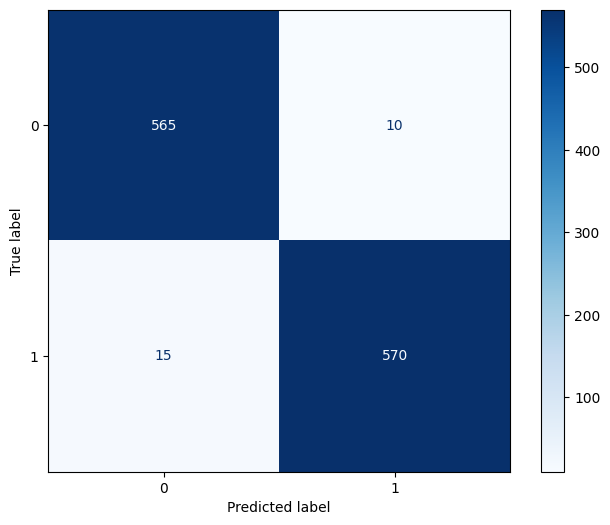

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred6)
print("Confusion Matrix:")
print(conf_matrix)
from sklearn.metrics import ConfusionMatrixDisplay
#Confusion matrix plot
fig, ax = plt.subplots(figsize=(8, 6))
cmd = ConfusionMatrixDisplay(conf_matrix)
cmd.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Predict Depression for a text Instance

def Predict_depression(model, tokenizer, text):
  tokenized_text = tokenizer.texts_to_sequences([text])
  tokenized_text_padded = pad_sequences(tokenized_text, maxlen = max_length, padding = padding_type, truncating = truncation_type)
  y_pred_prob = model.predict(tokenized_text_padded.reshape(1, -1))[0][0]
  print(text)
  if y_pred_prob >= 0.5:
    print('Depressed.')
  else:
    print('Not depressed.')

In [ ]:
Predict_depression(loaded_model6, tokenizer, X_train[20])

1/1 [==============================] - 0s 99ms/step
Depressed.


# Model 7 (Bert Base Uncased)

In [ ]:
# Define dataset class

class TextClassificationDataset(Dataset): # This custom class is a custom class of Dataset
  def __init__(self, texts, labels, tokenizer, max_length): # This constructor method takes in 4 arguments: texts and labels lists, tokenizer and max_length
    self.texts = texts # The texts list argument is assigned to an attribute called texts
    self.labels = labels # The labels list argument is assigned to an attribute called labels
    self.tokenizer = tokenizer # The tokenizer object (possibly from huggingface) argument is assigned to an attribute called tokenizer
    self.max_length = max_length # The max_length argument is assigned to an attribute called max_length (GPT: The maximum length to which each text instance will be truncated or padded during tokenization.)

  def __len__(self):
    return len(self.texts) # This method defines the __len__ function for the dataset, which returns the length of the dataset (i.e., the number of text instances).

  def __getitem__(self, idx): # This method defines the __getitem__ function for the dataset, which allows indexing into the dataset to retrieve individual samples.
    text = self.texts[idx]  # Retrieves the text instance at the specified index idx from the texts list.
    label = self.labels[idx]  # Retrieves the corresponding label for the text instance at index idx from the labels list.
    encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True) # Tokenizes the 'text instance' using the specified tokenizer (self.tokenizer) with the provided parameters, such as max_length, padding, and truncation. This converts the text into numerical tokens that can be processed by a neural network.
    return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)} # Returns a dictionary containing the tokenized text (input_ids) along with its attention mask (attention_mask) and the corresponding label. The tokenized text and attention mask are flattened to convert them into 1D tensors. The label is converted to a PyTorch tensor using torch.tensor(label).




In [ ]:
# Define the model class

class BERTClassifier(nn.Module): # A custom model class is defined which subclasses the nn.Module
  def __init__(self, bert_model_name, num_classes): # The constructor method takes in the pretrained bert model name and number of classes as the argument which determines the size of the output layer of the neural network..
    super(BERTClassifier, self).__init__() # This line calls the constructor of the parent class (nn.Module) to initialize the BERTClassifier class.
    self.bert = BertModel.from_pretrained(bert_model_name) # The pretrained Bert model is loaded from hugging face transformers library as an attribute
    self.dropout = nn.Dropout(0.1) # This line creates a dropout layer with a dropout probability of 0.1. as an attribute
    self.fc = nn.Linear(self.bert.config.hidden_size, num_classes) # A dense (fully connected) layer for classification. This line defines a fully connected (linear) layer (fc) that maps the BERT output to the number of classes (num_classes). The input size of this layer is determined by the hidden_size attribute of the BERT model configuration.

  def forward(self, input_ids, attention_mask): # This method defines the forward pass of the neural network model, which specifies how input data flows through the model layers.
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask) # This line passes the input token IDs (input_ids) and attention mask (attention_mask) to the BERT model (self.bert) to obtain the model outputs.
    pooled_output = outputs.pooler_output # This line extracts the pooled output from the BERT model outputs. The pooled output is a fixed-size representation of the input text that captures its semantic meaning, typically obtained from the [CLS] token.
    x = self.dropout(pooled_output) # This line applies dropout regularization to the pooled output obtained from BERT.
    logits = self.fc(x) # This line applies the fully connected layer (fc) to the output of the dropout layer to obtain the logits (raw scores) for each class.
    return logits # This line returns the logits, which represent the model's predictions for each class. These logits can be further processed with a softmax function to obtain probabilities for each class.

In [ ]:
# Function defined to train the model

def train(model, data_loader, optimizer, scheduler, device): # This model has 5 parameters: the model to be used, The PyTorch DataLoader object containing the training data, the optimizer, The learning rate scheduler, which adjusts the learning rate during training, and the device (CPU or GPU).
  model.train() # This line sets the model to training mode.
  for batch in data_loader: # This loop iterates over batches of data from the data_loader, which contains batches of input samples along with their corresponding labels.
    optimizer.zero_grad() # This line clears the gradients of all optimized tensors. Gradients need to be cleared before calculating gradients for the next batch to avoid accumulating gradients from previous batches.
    input_ids = batch['input_ids'].to(device) # This line extracts the input token IDs from the current batch and moves them to the specified device (CPU or GPU).
    attention_mask = batch['attention_mask'].to(device) # This line extracts the attention masks from the current batch and moves them to the specified device
    labels = batch['label'].to(device) # This line extracts the labels from the current batch and moves them to the specified device.
    outputs = model(input_ids=input_ids, attention_mask=attention_mask) # This line passes the input token IDs and attention masks through the model to obtain the model's predictions (logits) for each sample in the batch.
    loss = nn.CrossEntropyLoss()(outputs, labels) # This line computes the loss between the model's predictions (outputs) and the actual labels (labels). The loss is calculated using the Cross Entropy Loss function, which is commonly used for multi-class classification tasks.
    loss.backward() # This line computes the gradients of the loss with respect to the model parameters.
    optimizer.step() # This line updates the model parameters using the gradients computed during the backward pass, based on the optimization algorithm used (e.g., SGD, Adam).
    scheduler.step() # This line updates the learning rate scheduler, which adjusts the learning rate based on the scheduler's policy (e.g., reducing the learning rate over time).

In [ ]:
# Function defined to evaluate the model on performance metrics

def evaluate(model, data_loader, device): # This function takes in 3 parametesr, the model to be evaluated, the data loader object and the device used.
  model.eval() # This line sets the model to evaluation mode. This is important because some layers, such as dropout and batch normalization, behave differently during training and evaluation.
  predictions = [] # This line initializes an empty lists to store the model's predictions.
  actual_labels = [] # This line initializes an empty list the actual labels from the dataset.
  with torch.no_grad(): # This context manager is used to temporarily disable gradient calculation during evaluation. It speeds up computation and reduces memory usage since gradients are not needed during evaluation.
    for batch in data_loader: # This loop iterates over batches of data from the data_loader, which contains batches of input samples along with their corresponding labels.
      input_ids = batch['input_ids'].to(device) # These lines extract the input token IDs, attention masks, and labels from the current batch and move them to the specified device (CPU or GPU).
      attention_mask = batch['attention_mask'].to(device) # Do
      labels = batch['label'].to(device) # Do
      outputs = model(input_ids=input_ids, attention_mask=attention_mask) # This line passes the input token IDs and attention masks through the model to obtain the model's predictions (logits) for 'each sample' in the 'batch'.
      _, preds = torch.max(outputs, dim=1) # This line of code uses the torch.max() function to find the index of the maximum value along the specified dimension (in this case, dimension 1) of the outputs tensor. The output of this operation consists of two parts: the maximum values and their corresponding indices. Since we are interested only in the indices (which represent the predicted class labels), we use the underscore _ to discard the maximum values, and we assign the indices to the variable preds.
      predictions.extend(preds.cpu().tolist()) # This is similar to appending, as we append predictions of each batches
      actual_labels.extend(labels.cpu().tolist()) # # This is similar to appending, as we append labels of each batches
  return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions, digits = 4), actual_labels, predictions

In [ ]:
# Function defined to predict depression from an instance of text

def predict_depression(text, model, tokenizer, device, max_length=128): # This function is used to generate predictions for an instance of text
  model.eval() # model is set to evaluation mode
  encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True) # We get the encodings of the text from the tokenizer
  input_ids = encoding['input_ids'].to(device) # We get the input ids of the tokenized text and transfer them to gpu
  attention_mask = encoding['attention_mask'].to(device) # We get attention mask of the tokenized text and transfer them to gpu

  with torch.no_grad(): # For predictions this context manager is used
    outputs = model(input_ids=input_ids, attention_mask=attention_mask) # We get the outputs from the model.
    _, preds = torch.max(outputs, dim=1) # The output is the form of batch x num of classes, so we get the max value from the num of classes dimensions which is the predicted value
  ## Added later
  print("Shape of preds tensor:", preds.shape)
  print("Contents of preds tensor:", preds)
  ## Added later
  return "Depressed" if preds.item() == 1 else "Not depressed"

In [ ]:
# Set up parameters
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 256
batch_size = 32
num_epochs = 50
learning_rate = 2e-5

In [ ]:
# Initialize tokenizer, datasets and dataloaders
tokenizer_bert = BertTokenizer.from_pretrained(bert_model_name) # Initialize BERT toknenizer for the pretrained model, in this case 'bert_base_uncased'

train_dataset = TextClassificationDataset(X_train, y_train, tokenizer_bert, max_length)
val_dataset = TextClassificationDataset(X_val, y_val, tokenizer_bert, max_length)
test_dataset = TextClassificationDataset(X_test, y_test, tokenizer_bert, max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Device is set to gpu if available, else is set to CPU
model = BERTClassifier(bert_model_name, num_classes).to(device) # The model to be used is instantiated and moved to the GPU

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
optimizer = AdamW(model.parameters(), lr=learning_rate) # instantiating optimizer
total_steps = len(train_dataloader) * num_epochs # len(train_dataloader) returns the number of batches in the training dataset. num_epochs is the total number of epochs for training, which indicates how many times the entire dataset will be passed through the model. Multiplying the number of batches by the number of epochs gives the 'total number of steps (batches)' that will be taken during training.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps) # To be added later

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Initialize early stopping parameters (NEW ADDED)
patience = 3
best_val_acc = 0
counter = 0

In [ ]:
# # start recording training time
# start_time = time.time()
%%time

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)

    # Evaluate on the training set during training (for training accuracy)
    accuracy, report, _, _ = evaluate(model, train_dataloader, device)
    print(f"Training Accuracy: {accuracy:.4f}")
    print(report)

    # Evaluate on the validation set during training
    val_acc, _, _, _ = evaluate(model, val_dataloader, device)
    print(f"Validation Accuracy: {val_acc:.4f}")

    # Check for early stopping
    if val_acc > best_val_acc:  # if accuracy improves
        best_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), '/content/drive/MyDrive/CSE 713 Project/Trained Models/Model_7_Bert_Base_Uncased/model7.pt') # Save the best model
    else:  # if accuracy does not improve
        counter += 1
        print(f"EarlyStopping counter: {counter} out of {patience}")
        if counter == patience:
            print("Early stopping")
            break

# # stop recording training time
# end_time = time.time()
# execution_time = end_time - start_time
# print("Execution Time for training:", execution_time, "seconds")

Epoch 1/50
Training Accuracy: 0.9738
              precision    recall  f1-score   support

           0     0.9510    0.9993    0.9745      2717
           1     0.9992    0.9480    0.9730      2694

    accuracy                         0.9738      5411
   macro avg     0.9751    0.9736    0.9737      5411
weighted avg     0.9750    0.9738    0.9737      5411

Validation Accuracy: 0.9698
Epoch 2/50
Training Accuracy: 0.9969
              precision    recall  f1-score   support

           0     0.9949    0.9989    0.9969      2717
           1     0.9989    0.9948    0.9968      2694

    accuracy                         0.9969      5411
   macro avg     0.9969    0.9968    0.9969      5411
weighted avg     0.9969    0.9969    0.9969      5411

Validation Accuracy: 0.9750
Epoch 3/50
Training Accuracy: 0.9978
              precision    recall  f1-score   support

           0     0.9982    0.9974    0.9978      2717
           1     0.9974    0.9981    0.9978      2694

    accuracy   

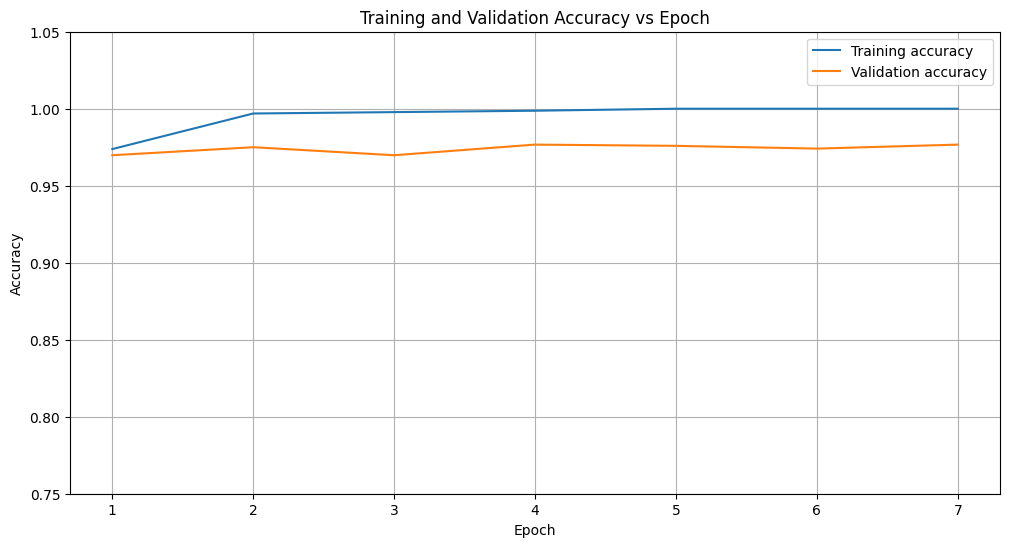

In [ ]:
train_acc = [0.9738, 0.9969, 0.9978, 0.9987, 1.0000, 1.0000, 1.0000]
val_acc = [0.9698, 0.9750, 0.9698, 0.9767, 0.9759, 0.9741, 0.9767]

epochs = range(1, 8)

# Plotting accuracy vs epoch
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and Validation Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0.75, 1.05)  # Set y-axis limits from 0.75 to 1.0
plt.show()

In [ ]:
model7 = BERTClassifier(bert_model_name, num_classes).to(device)
model7.load_state_dict(torch.load('/content/drive/MyDrive/CSE 713 Project/Trained Models/model7.pt'))

<All keys matched successfully>

In [ ]:
# Evaluate on the test set after training
test_accuracy, test_report, actual_labels, pred = evaluate(model7, test_dataloader, device)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(test_report)

Test Accuracy: 0.9802
              precision    recall  f1-score   support

           0     0.9662    0.9948    0.9803       575
           1     0.9947    0.9658    0.9801       585

    accuracy                         0.9802      1160
   macro avg     0.9805    0.9803    0.9802      1160
weighted avg     0.9806    0.9802    0.9802      1160



In [ ]:

# Get the indices where y_pred values are not equal to y_test
indices = [index for index, (pred, actual) in enumerate(zip(actual_labels, 0)) if pred != actual]

print("Indices where y_pred values are not equal to y_test:", indices)

TypeError: 'int' object is not iterable

In [ ]:
X_test[134]

'not handling the loss of my father barely making it day to day i m in so much pain i don t think i can make it much longer'

Confusion Matrix:
[[572   3]
 [ 20 565]]


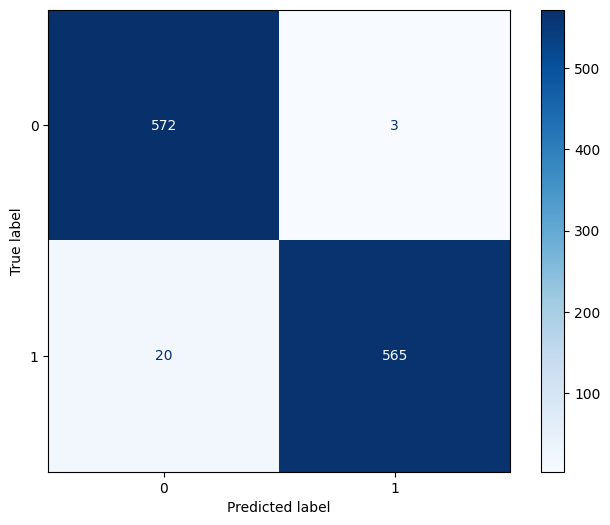

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(actual_labels, pred)
print("Confusion Matrix:")
print(conf_matrix)
from sklearn.metrics import ConfusionMatrixDisplay
#Confusion matrix plot
fig, ax = plt.subplots(figsize=(8, 6))
cmd = ConfusionMatrixDisplay(conf_matrix)
cmd.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Test sentiment prediction
test_text = X_test[0]
Depression_state = predict_depression(test_text, model7, tokenizer_bert, device)
print(test_text)
print(Depression_state)

Shape of preds tensor: torch.Size([1])
Contents of preds tensor: tensor([0], device='cuda:0')
The movie was so bad and I would not recommend it to anyone.
Predicted sentiment: not depressed


# LIME

## LIME Explanation for RNN Models

In [ ]:
from lime.lime_text import LimeTextExplainer

In [ ]:
# Choose an instance from the test set to explain (for example, the first instance)
test_instance_idx = 951
test_instance = X_test[test_instance_idx]

loaded_model = loaded_model

In [ ]:
# Explain an instance using LIME
explainer = LimeTextExplainer(class_names=['Not Depressed', 'Is Depressed'])


# Define the prediction function for the model
def predict_fn(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)
    # Predict probabilities for both classes
    probabilities = loaded_model.predict(padded_sequences) # model4 is selected
    return np.hstack((1 - probabilities, probabilities))

In [ ]:
# Explain the instance
explanation = explainer.explain_instance(test_instance, predict_fn, num_features=15)

157/157 [==============================] - 3s 19ms/step


In [ ]:
# Show explanation
explanation.show_in_notebook(text=True)

## LIME Explanation for BERT Base Uncased

In [ ]:
# Choose an instance from the test set to explain (for example, the first instance)
test_instance_idx = 951
test_instance = X_test[test_instance_idx]

In [ ]:
def predict_probabilities(texts, model = model7, tokenizer = tokenizer_bert, device = device, max_length=128):
    model.eval() # Set model to evaluation mode
    probabilities = []

    for text in texts:
        # Tokenize the text
        encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            # Get model predictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probabilities.append(torch.softmax(outputs, dim=1).cpu().numpy().squeeze())

    return np.array(probabilities)

Correct Prediction

In [ ]:
# Generate LIME Explanations

explainer = LimeTextExplainer(class_names = ['Not Depressed', 'Is Depressed'])
explanation = explainer.explain_instance(test_instance, predict_probabilities, num_features=15)

In [ ]:
# Show explanation
explanation.show_in_notebook(text=True)